In [1]:
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import wrf
import datetime

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter


# import personal modules
# Path to modules
sys.path.append('../../modules')

# # Import my modules
from wrf_funcs_preprocess import select_single_coord_WRF
# from ar_funcs import get_ar_days, duration_stats
# from timeseries import select_months_ds
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines

In [2]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/sbarc/students/nash/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [28]:
fname_lst = ['35.18N_72.82E', '33.73N_74.82E', '42.85N_71.38E', '28.58N_77.20E']
ds_lst1 = []
for i, fname in enumerate(fname_lst):
    ## load wvf climatology data
    fname = path_to_data + 'wrf_hasia/d02/wvflux_{0}.nc'.format(fname)
    ds = xr.open_dataset(fname, engine='netcdf4')
    ds_lst1.append(ds)

ds_lst1

[<xarray.Dataset>
 Dimensions:   (Time: 284, bottom_top: 50)
 Coordinates:
     XTIME     (Time) float32 ...
   * Time      (Time) datetime64[ns] 1980-01-25T12:00:00 ... 2015-02-25T12:00:00
     lat       (Time) float32 ...
     lon       float32 ...
 Dimensions without coordinates: bottom_top
 Data variables:
     pressure  (Time, bottom_top) float32 ...
     ua        (Time, bottom_top) float32 ...
     va        (Time, bottom_top) float32 ...
     height    (Time, bottom_top) float32 ...
     QVAPOR    (Time, bottom_top) float32 ...
     HGT       (Time) float32 ...
     q         (Time, bottom_top) float32 ...
     wspd      (Time, bottom_top) float32 ...
     wvf       (Time, bottom_top) float32 ...
 Attributes:
     FieldType:    104
     MemoryOrder:  XYZ
     description:  pressure
     units:        hPa
     stagger:      ,
 <xarray.Dataset>
 Dimensions:   (Time: 411, bottom_top: 50)
 Coordinates:
     XTIME     (Time) float32 ...
   * Time      (Time) datetime64[ns] 1980-02-0

In [4]:
## load event wrf file

jan2002_fname = "/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00"
feb2010_fname = "/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00"

fname_lst = [jan2002_fname, feb2010_fname]


In [19]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)
# print(ptlst)

## add points from radiosonde locations
ptlst.append([71.38, 42.85]) # Station 38341
ptlst.append([77.20, 28.58]) # station 42182
ptlst = ptlst[:] ## already processed first point
print(ptlst)

[[72.82435477263415, 35.17734278984024], [74.82435477263417, 33.72734278984023], [71.38, 42.85], [77.2, 28.58]]


In [20]:
jan2002_times = pd.date_range(start='2002-01-13 00', end='2002-01-13 21', freq='3H')
feb2010_times = pd.date_range(start='2010-02-08 00', end='2010-02-08 21', freq='3H')
times_lst = [jan2002_times, feb2010_times]

In [21]:
varlst = ('pressure', 'ua', 'va', 'z', 'QVAPOR', 'HGT')
ds_lst = []
for j, pt in enumerate(ptlst):
    lat = pt[1]
    lon = pt[0]
    
    print(lat, lon)
    for i, (fname, times) in enumerate(zip(fname_lst, times_lst)):
        print(fname)
        timesteps = times
        wrfin = [fname] # needs to be put in a list for the select_single_coord function
        # now we can use this function to search the given wrf files for those timesteps and process the vertical values for the given location
        ds = select_single_coord_WRF(wrfin, varlst, lat, lon, timesteps)

        # # calculate specific humidity from mixing ratio (units: kg kg-1)
        # ds = ds.assign(q=lambda ds: np.divide(ds.QVAPOR, (1+ds.QVAPOR)))

        # compute vertical moisture flux (units: m s-1*kg kg-1)
        uq = ds.ua*ds.q
        vq = ds.va*ds.q
        ds = ds.assign(wvf=lambda ds: np.sqrt(uq**2 + vq**2))

        ds_lst.append(ds)



35.17734278984024 72.82435477263415
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  23
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  24
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  25
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  26
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  27
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  28
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  29
/home/hasia/2001/wrfout_d02_2002-01-10_03:00:00 timeidx is  30
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 timeidx is  31
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 timeidx is  32
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 timeidx is  33
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 timeidx is  34
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 timeidx is  35
/home/hasia/2009/wrfout_d02_2010-02-04_03:00:00 t

In [23]:
print(len(ds_lst))

ds_jan2002 = [ds_lst[0], ds_lst[2], ds_lst[4], ds_lst[6]]
ds_feb2010 = [ds_lst[1], ds_lst[3], ds_lst[5], ds_lst[7]]

8


### Plot WVF average over all AR days and Event WVF

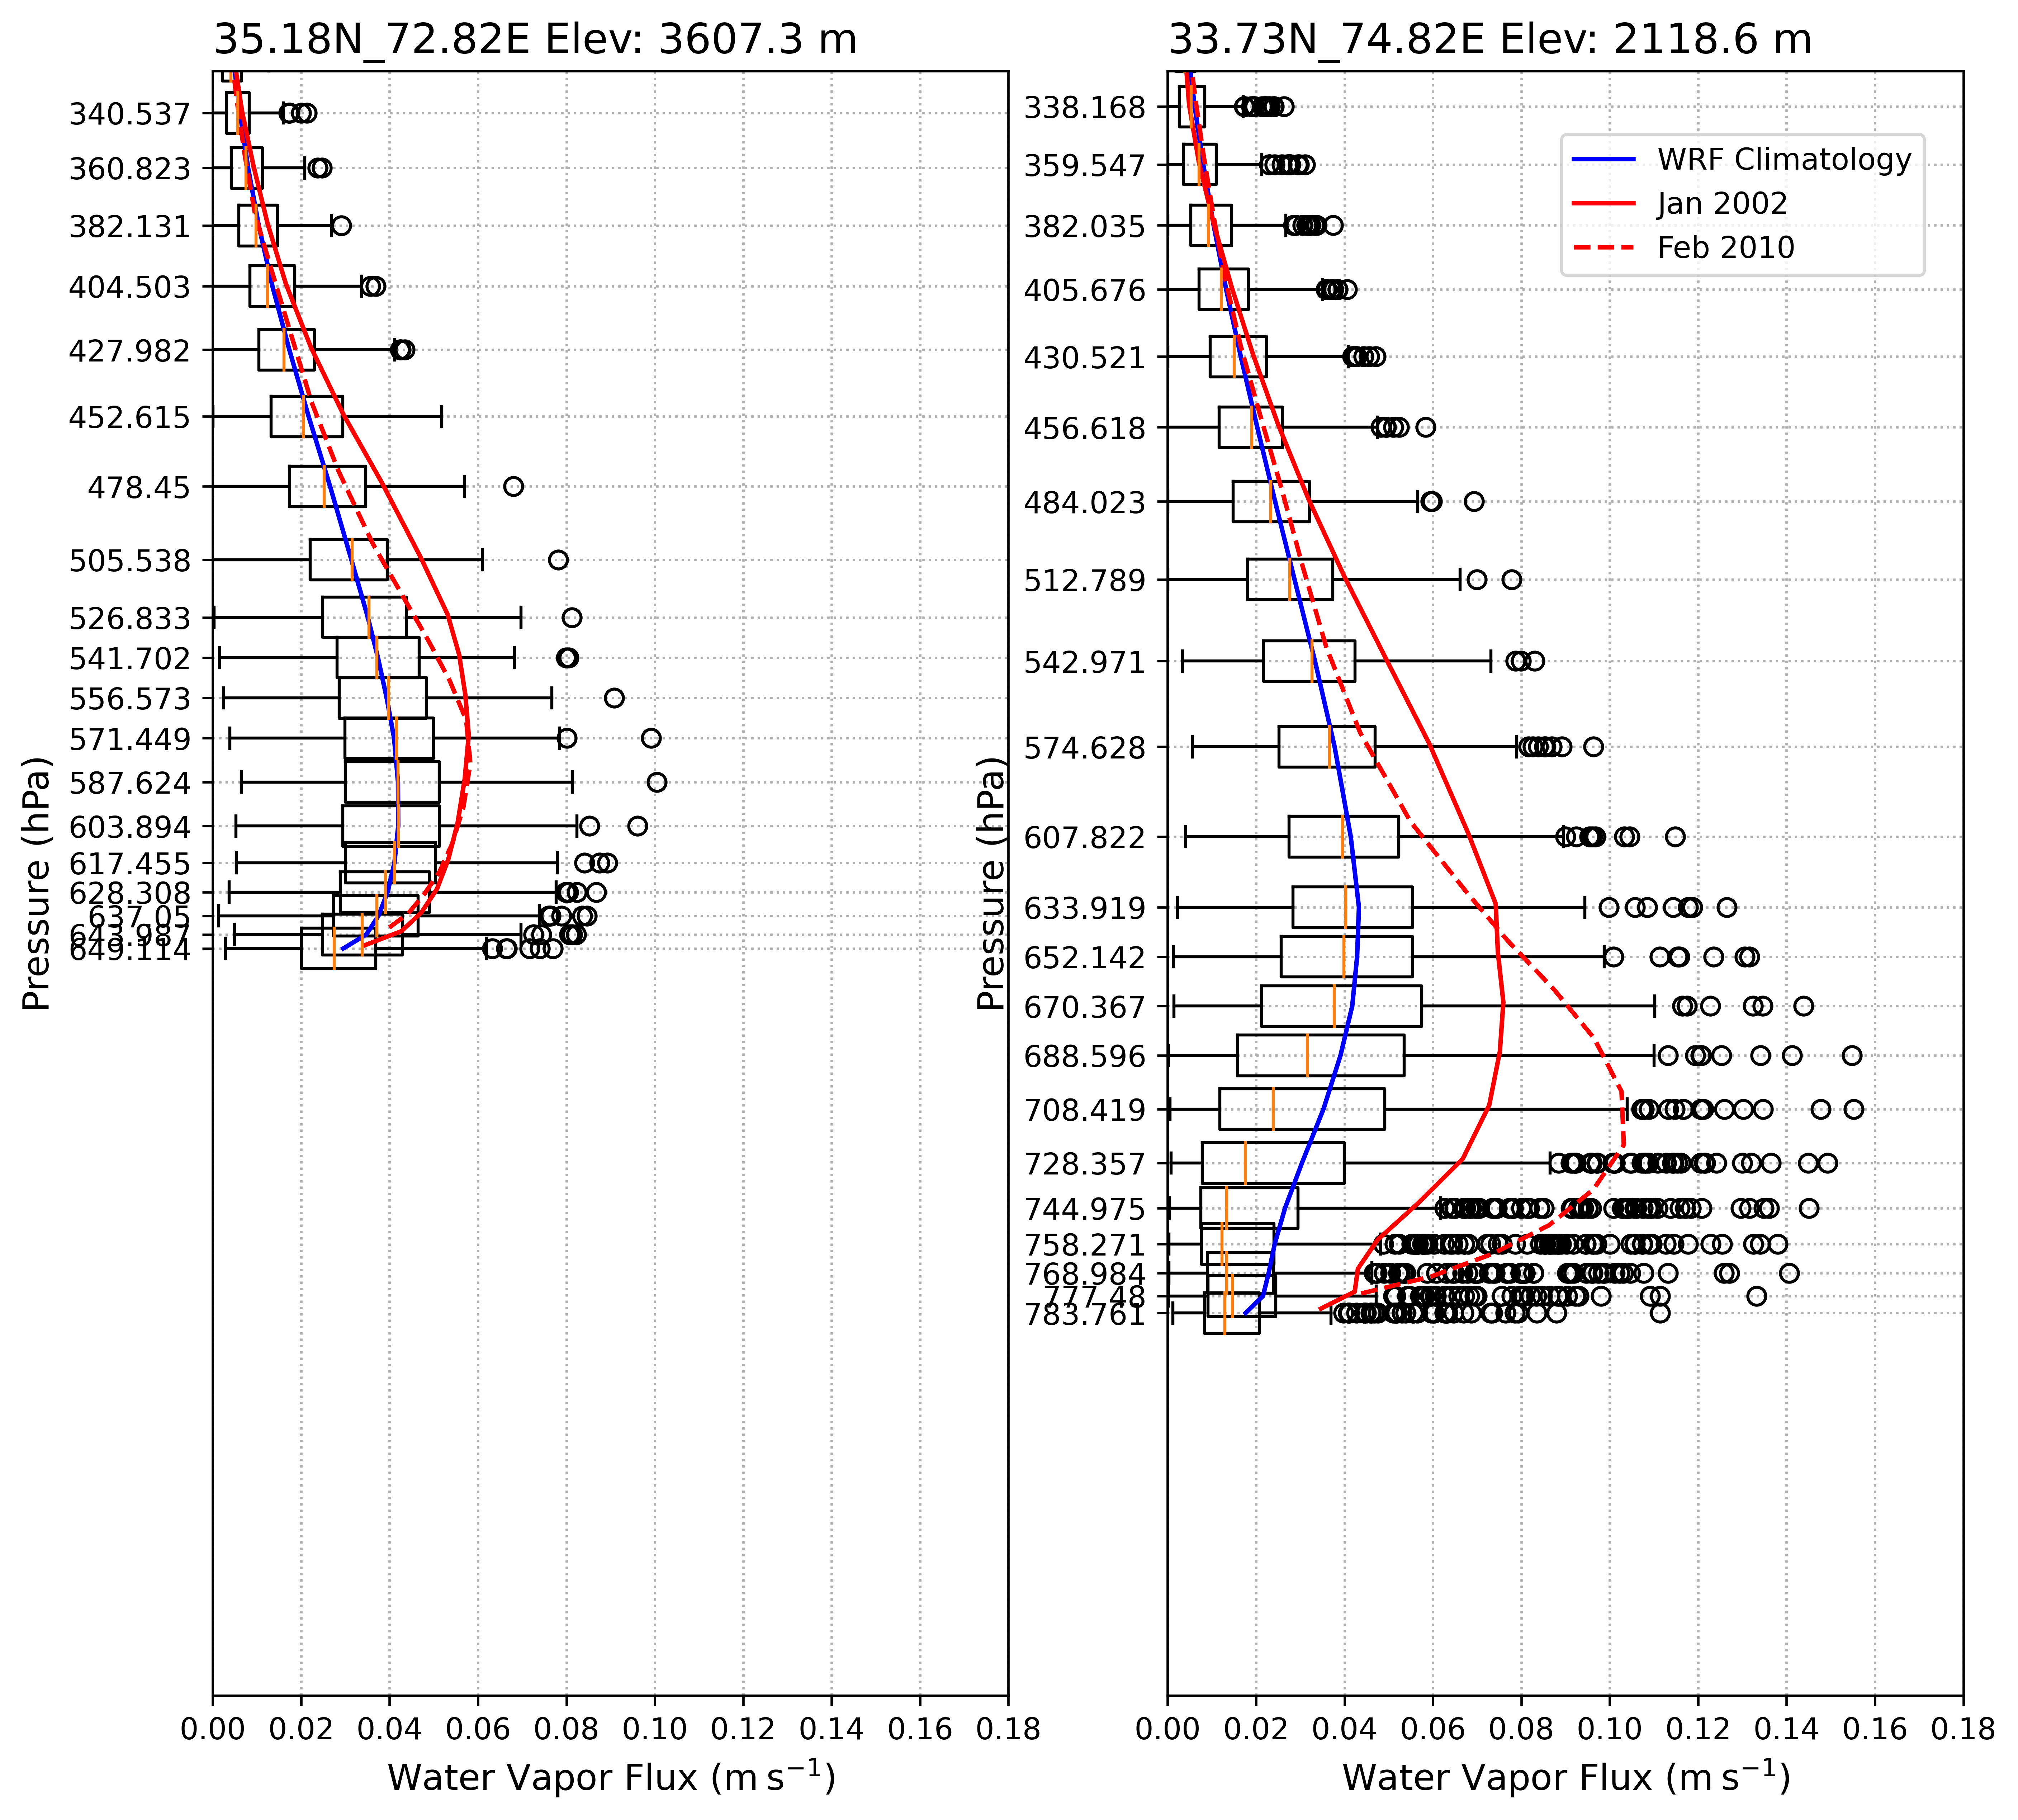

In [46]:
## figsize=(width,height (inches))
fig = plt.figure(figsize=(10.5,10.0))
fig.dpi = 600
fname = '../../figs/wvf_climatology'
fmt = 'png'
nrows = 1
ncols = 2

for i, (ds, ds1, ds2) in enumerate(zip(ds_lst1[:2], ds_jan2002[:2], ds_feb2010[:2])):
    ax = fig.add_subplot(nrows, ncols, i+1)
    data = ds.wvf.mean('Time').values
    data_jan2002 = ds1.wvf.mean('Time').values
    data_feb2010 = ds2.wvf.mean('Time').values
    
    x_levels = np.arange(0.0, 0.2, 0.02)
    y_levels = y_levels = np.array([900, 800, 800, 700, 600, 500, 400, 300])

    ax.boxplot(ds.wvf, vert=False, widths=15.0, positions=ds.pressure.mean('Time').values)

    clim = ax.plot(data, ds.pressure.mean('Time').values, 'b-', label='WRF Climatology')
    event_jan = ax.plot(data_jan2002, ds1.pressure.mean('Time').values, 'r-', label='Jan 2002')
    event_feb = ax.plot(data_feb2010, ds2.pressure.mean('Time').values, 'r--', label='Feb 2010')
    plt.gca().invert_yaxis()

    ax.set_ylim([925, 325])
    ax.set_xlim([0,0.18])
    ax.set_xticks(x_levels)
    # ax.set_yticks(y_levels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylabel('Pressure (hPa)', fontsize=12)
    ax.set_xlabel('Water Vapor Flux ($\mathrm{m \: s^{-1}}$)', fontsize=12)
    ax.grid(linestyle=':')
    height = ds.HGT.mean('Time').values
    plt.title(fname_lst[i]+ ' Elev: {:.1f} m'.format(height), fontsize=14, loc='left')
    
    if i == 1:
        ## add legend
        lns = clim+event_jan+event_feb
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc='upper right', bbox_to_anchor=(0.97, 0.97))



## Save figure
plt.savefig(fname, dpi=300, bbox_inches='tight')

plt.show()